# The Quantum Harmonic Oscillator 

The quantum harmonic oscilltor is a quantum system in which a molecule undergoes simple harmonic motion. The behavior of the molecule can be represented mathematically using the Schrödinger Equation. However, solving the equation often takes a lot of time and is computationally expensive. In the following chapter, we will introduce a framework for approximating the equation in such a way that the time it takes to solve is much lower. This is acheived through a collection of methods known as Reduced Basis Methods. 

## Table of Contents
### Introduction to Quantum Harmonic Oscillator
### High Fidelity Solver
#### - Finite Difference Method
#### - Comparison to Exact
### Reduced Basic Method
#### - SVD/Principal Components
#### - M0, M1, and N Matrices
#### - Compare Solutions 
### Conclusion

### Introduction to the Quantum Harmonic Oscillator and Schrödinger Equation
The quantum harmonic oscillator system is comprised of a molecule in simple harmonic motion. While an object in simple harmonic motion can be described with less complicated equations, the inclusion of quantum mechanics complicates things for a molecule in harmonic motion. Regardless, the system is well known and established. For that reason, it is a great toy problem for demonstrating the power of RBMs. 

$$ (\frac{d^2}{dx^2} + \alpha x^2 - \lambda )\phi(x) = 0 $$

The first term is the second derivative, which can be expressed as a matrix. It describes the kinetic energy of the system. The second term is the potential energy of the system, and it is multiplied by some value alpha. Alpha is the harmonic parameter, and lambda is the eigenvalue. According to textbooks, $$ \lambda = 2mE/\hbar^2 $$ and $$ a = (m\omega/\hbar)^2 $$

This system/equation does have analytical soltions. However, most quantum systems do not have analytical solutions due to their complexity. Because the quantum harmonic oscillator system can be solved easily, we can easily compare the different methods in terms of error and time. 

### High Fidelity Solver
First, we will create a high fidelity solver. Using this method will take some time, but it will have a realtively low error. This method entails creating matrices for each of the terms in the equation. The kinetic energy term and the potential energy term. T is the kinetic term. V is the potential term, and the overall system can be represented by H for some value of alpha. 
$$ T\phi(x)=-\frac{d^2}{dx^2}\phi(x),\quad V_\alpha(x)\phi(x)=\alpha x^2\phi(x),\quad H_\alpha(x)=T+V(x) $$

Here are the libraries we will use in the following code

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy as sci
from scipy import optimize
import time 
from scipy import linalg

We now must create the functions to represent the terms in the equation above. 
The first function is the second derivative, and it creates it in a matrix form. The next term creates the potential matrix. The third equation combines them both. 

In [14]:

def hf_second_derivative(xgrid):
    N = len(xgrid)
    dx = xgrid[1] - xgrid[0]

    # Generate the matrix for the second derivative using a five-point stencil
    main_diag = np.ones(N) * (-5.0 / 2 / dx**2)
    off_diag = np.ones(N - 1) * 4 / 3 / dx**2
    off_diag2 = np.ones(N - 2) * (-1.0 / (12 * dx**2))

    D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(
      off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2)

    return D2
    
def hf_potential(xgrid):
      return np.diag(xgrid**2)


We can determine the exact solutions of the quantum harmonic oscillator, because it isn't too complicated to solve from a mathematical standpoint. So, we can use the exact lambda function to determine the error in our programmed solutions. 

In [15]:
def getExactLambda(alpha):
  n = 0
  return 2 * (.5 + n) * np.sqrt(alpha / 1**2)

#### Finite Difference Method
Finite difference method discretizes the space and divides the wavefunction of the particle into some amount of points. We can use this to simplify the wavefunction and treat it as a collection of points. This method is meant to find the high fidelity solution to the system. 

Below are some variables needed to apply this method. Firstly, numpy is used to create the space over which the wavefunction is discretized. Some alpha values are also established which will be used later on. 

In [16]:
x_max = 10.0
h = 10**(-1)
x = np.arange(-x_max, x_max + h, h)
N_grid = x.shape[0]
alphas = np.arange(0.5, 15.5, 0.5)
m = np.zeros((len(alphas), N_grid))

The timing function is meant to determine the time it takes to solve the high fidelity solution for a certain alpha value. The next functions combine the kinetic and potential terms, and then solve for the eigenvalues and eigenvectors. 

In [17]:
def timing(H, int):
  solveTime = []
  for i in range(int):
    time0 = time.time()
    evals, evects = np.linalg.eigh(H)
    time1 = time.time()
  solveTime.append(time1-time0)
  avg = sum(solveTime)/len(solveTime)
  return avg

def HO_creator(alpha, D2Mat, vpot):
  return -D2Mat + alpha * vpot

def HO_solver(H):
  evals, evects = np.linalg.eigh(H)
  solveTime = timing(H, 10)
  return evals, evects, solveTime


Below we have to create functions for each different spacing. The different spacings, or h values, increase how big the matrix for the kinetic and potential terms will be. A smaller h value corresponds to a longer computing time. Warning, depending on how small the h values are, the code might run very slowly!

In [18]:
def create_functions(h):
  x_max = 10.0 
  x = np.arange(-x_max, x_max + h, h)
  D20 = hf_second_derivative(x)
  V0 = hf_potential(x)
  return D20, V0


In [19]:
h_list = [1/10, 1/20, 1/30]

htimes = []
herrors = []

i = 0
for h in h_list:
  D20, V0 = create_functions(h)
  for alpha in range(5, 105, 5):
    alpha = alpha/10

    exactEigenvalue = getExactLambda(alpha)
    
    H= HO_creator(alpha, D20, V0)
    evals, evects, t1me = HO_solver(H)

    err = abs(((evals[0]-exactEigenvalue)/exactEigenvalue))

    htimes.append(t1me)
    herrors.append(err)


Below, we create a vector of solutions. It consists of the solutions for each alpha value in the list above. These solutions correspond to the wavefunctions for each solved system. You can see many of these wavefunctions plotted under the next block of code. Notice that they look pretty similar!

In [20]:
for i,alpha in enumerate(alphas):
    alpha = alphas[i]
    H = HO_creator(alpha, D20, V0)
    evals, evects, Stime = HO_solver(H)
    # m[i] = (evects[0] / np.linalg.norm(evects[0])*np.sign(evects[0][  int(len(x)/2)  ]))
    # m[i] = evects[0] / np.linalg.norm(evects[0])*np.sign(evects[0][  int(len(x)/2)  ])
    m[i] = evects[:,0]


ValueError: could not broadcast input array from shape (601,) into shape (201,)

ValueError: x and y must have same first dimension, but have shapes (201,) and (30,)

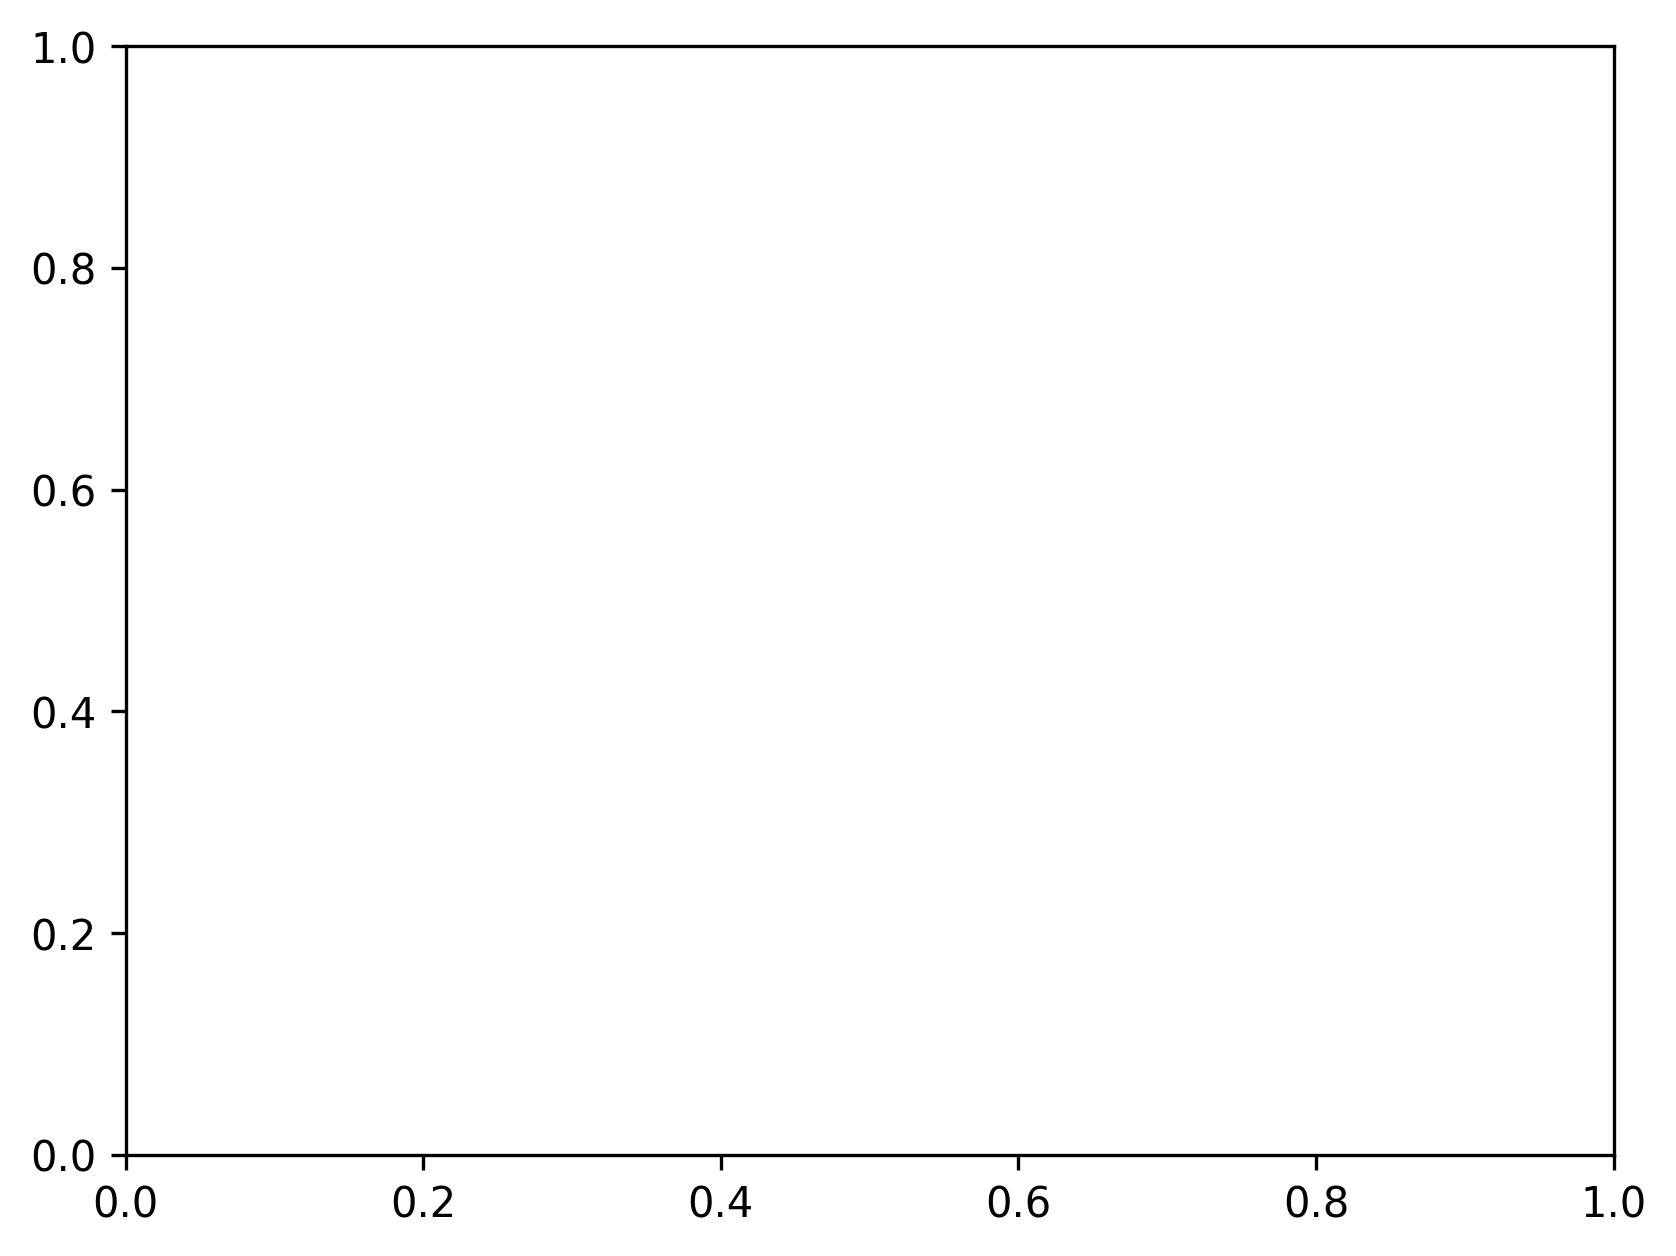

In [ ]:
fig, ax = plt.subplots(dpi=300)

for i in range(len(m)):
   ax.plot(x, m[i])

ax.set_title("Super Plot :)")
ax.set_xlabel("x")
ax.set_ylabel("Wave Functions")

plt.show()

One last thing. Let's graph the time it takes for these solutions to be computed and the error relative to an analytical solution. Notice a couple of things. Firstly, the error is really small for the high fidelity solution! This is great. Secondly, each of the "clumps" of points correspond to a different h value. Try to see if you can figure out which h value corresponds to which clump :)

/tmp/ipykernel_2411/1821265767.py:11: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  catAx.set(xscale='log',yscale='log',
/tmp/ipykernel_2411/1821265767.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  catAx.set(xscale='log',yscale='log',


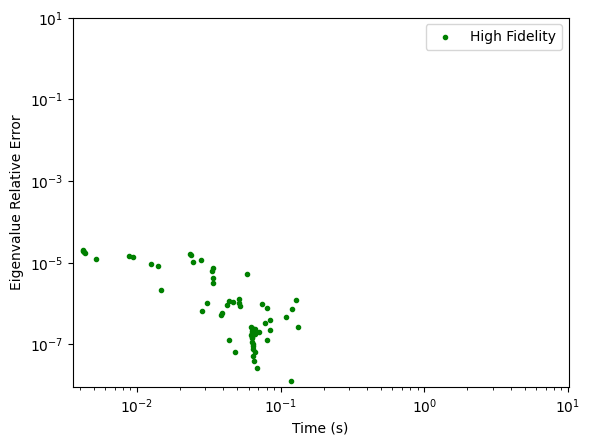

In [ ]:
maxT = max(htimes) + 10
minT = min(htimes) - 10
maxEr = max(herrors) + 10
minEr = min(herrors) - 10

catFig, catAx = plt.subplots()

catAx.scatter(htimes,herrors,color='green',
               marker='.',label='High Fidelity')

catAx.set(xscale='log',yscale='log',
           xlabel='Time (s)',ylabel='Eigenvalue Relative Error',
           xlim=(minT, maxT),ylim=(minEr,maxEr))

plt.legend()
plt.show()

### Reduced Basis Method
That's super cool, and it's great that we were able to do that. But, what if we can make it faster? In a simple system like this, speed isn't the biggest deal in the world. However, in more complicated systems, time becomes much more important, and speeding up the system is neccesary. 

#### SVD/PCA

For this approach to RBM, we use the high fidelity solver to build our approximation. In the following code we apply a machine learning technique to the data that effectively puts in a lower dimensionality space. If you aren't familiar with this idea, take a look at the following article: 

https://builtin.com/data-science/step-step-explanation-principal-component-analysis

(not sure if I'm allowed to put this here)

Luckily, we don't have to do the heavy lifting for this step. Instead, we can rely on the linalg.svd function from numpy. Work smarter not harder!

In [ ]:
U, sigma, Vh = np.linalg.svd(m)
components = 3
reduced_basis = Vh[:components]

reduced_basis = [reduced_basis[i]*np.sign(reduced_basis[i][  int(len(x)/2)  ]) for i in range(len(reduced_basis))]

Curious what these components look like? Run the code below to see. Graph as many components as you want in the system. More components = more time, smaller error. For this example, we'll use three. 

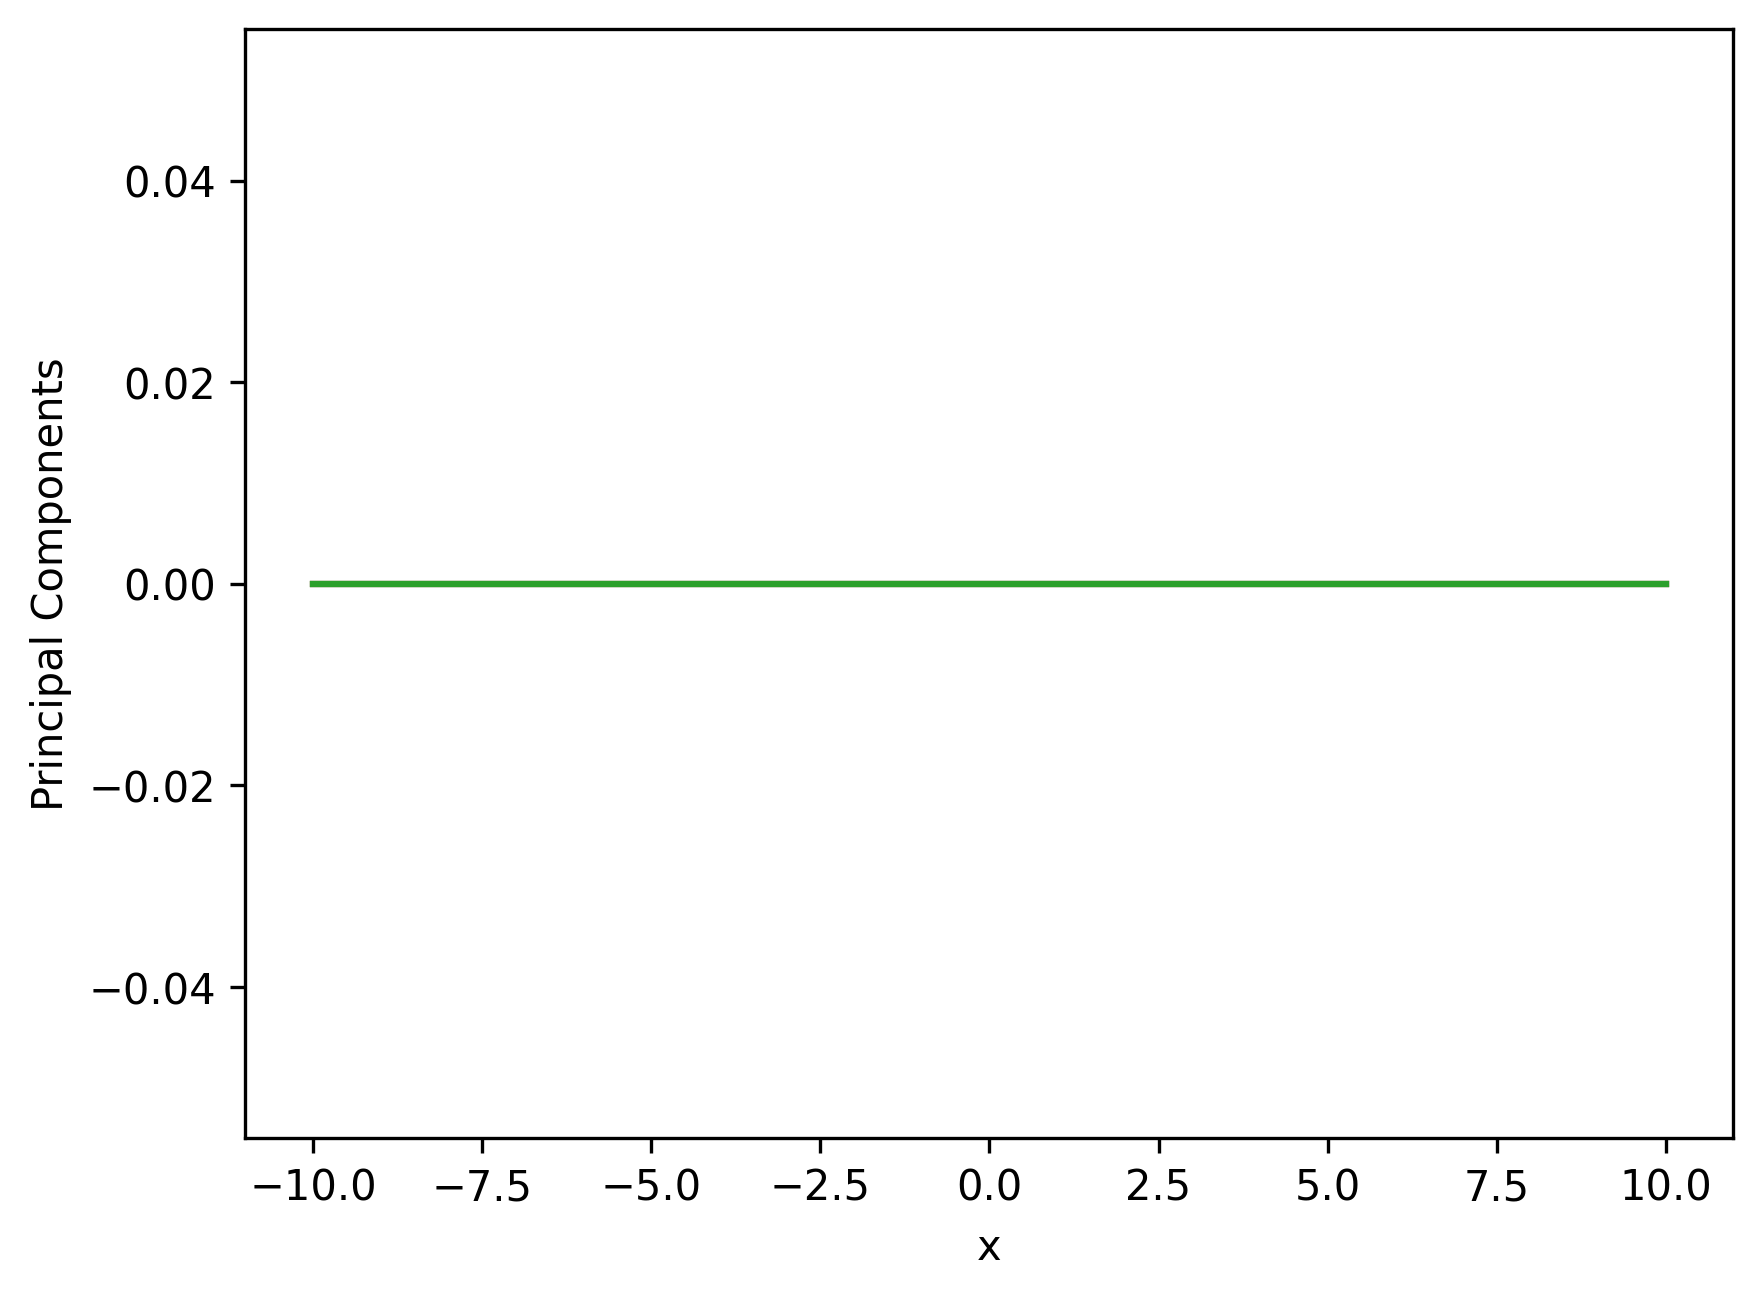

In [ ]:
fig, ax = plt.subplots(dpi=300)


for i in range(len(reduced_basis)):
    ax.plot(x, reduced_basis[i])

ax.set_xlabel("x")
ax.set_ylabel("Principal Components")

plt.show()

From here we establish some of the variables and functions that we will need in the next part. 

In [ ]:
alphas =  [.5,2,5,7,10,15]
x_max = 10.0
h = 10**(-1)
x = np.arange(-x_max, x_max + h, h)


In [ ]:

def second_derivative_matrix(xgrid):
    size = len(xgrid)
    offDiag = np.zeros(size)
    offDiag[1] = 1
        
    H = -1*(-2*np.identity(size) + linalg.toeplitz(offDiag))/h**2
    return H

def potential_matrix(xgrid):
    return np.diag(xgrid**2)

def H_creator(alpha, xgrid):
    d2 = second_derivative_matrix(xgrid)
    pot = potential_matrix(xgrid)
    H = d2 + alpha*pot
    return H

def hf_solve(H):
    evals, evects = np.linalg.eigh(H)
    return evals, evects

d2 = second_derivative_matrix(x)
pot = potential_matrix(x)

#### - M0, M1, and N Matrices

We already have worked with the system represented by the following function:

$$ (\frac{d^2}{dx^2} + \alpha x^2 - \lambda )\phi(x) = 0 $$

However, we can put forth a reformulation of the math.

Because we are solving an eigenvalue problem, we can arrive at a set of different-looking equations, using the same set of judges $\{\psi_i(x)\}_{i=1}^n$ as before. We can simply plug $\hat{\phi}_{\alpha_k}$ into the Schrodinger equation and project both sides onto the judges, writing

\begin{align}
\sum_{i=1}^na_i\langle \psi_j|H_{\alpha_k}|\phi_i\rangle=\lambda\sum_{i=1}^na_i\langle\psi_j|\phi_i\rangle.
\end{align}

Define now two matrices:

\begin{align}
M_{ij}(\alpha)\equiv \langle\psi_j|H_\alpha|\phi_i\rangle,\quad N_{ij}\equiv\langle\psi_j|\phi_i\rangle.
\end{align}

These are both $n\times n$ matrices, and we now have a generalized eigenvalue problem for $\vec{a}$:

\begin{align}
M(\alpha)\vec{a}=\lambda N\vec{a}.
\end{align}

Situationally, this may be quicker to solve than finding the roots of the nonlinear system that results from the "traditional" RBM approach.

As with traditional RBM approaches, this is only helpful if we can evaluate $M(\alpha)$ quickly for different $\alpha$ values. For the HO, this is not too hard: we can write

\begin{align}
\langle\psi_j|H_\alpha|\phi_i\rangle=\langle\psi_j|T|\phi_i\rangle+\alpha\langle \psi_j|x^2|\phi_i\rangle\equiv M_{ij}^{(0)}+\alpha M_{ij}^{(1)}.
\end{align}

Our eigenvalue equation is then

\begin{align}
[M^{(0)}+\alpha M^{(1)}]\vec{a}=\lambda N\vec{a},
\end{align}

and all of $M^{(0)},M^{(1)}$ and $N$ can be precomputed.
 
A code implementation is given below.


In [ ]:
psi = np.array(reduced_basis)
phi = np.array(reduced_basis)

In [ ]:
def M0(psi, phi, d2, i, j):
    M0 = np.dot(psi[j], np.dot(d2, phi[i]))
    return M0

def M1(psi, phi, pot, i, j):
    M1 = np.dot(psi[j], np.dot(pot, phi[i]))
    return M1


In [ ]:
compvec = np.zeros(components)
array = []
for i in range(components):
    array.append(compvec)
H_hat = np.array(array)
M1 = np.array(array)
M2 = np.array(array)
N = np.array(array)

In [ ]:
def create_H_hat(alpha, phi, psi, pot, d2):
    for i in range(components):
        for j in range(i, components):
            M1[i][j] = phi[i] @ d2 @ psi[j]
            M1[j][i] = M1[i][j]
            M2[i][j] = phi[i] @ pot @ psi[j]
            M2[j][i] = M2[i][j]
    H_hat = M1 + alpha*M2
    return H_hat


In [ ]:
H_hat = create_H_hat(5, phi, psi, pot, d2)

In [ ]:
def create_N(psi, phi):
    for i in range(components):
        for j in range(i, components):
            N[i,j] = phi[i] @ psi[j]
            N[j,i] = N[i,j]
    return N

N = create_N(psi, phi)

The following function may be called for any value of alpha and provide a decent approximation. To get an idea of how well it works, we will graph the time and error below. We will graphically compare it to the high fidelity solution. 

In [ ]:
def RBM(alpha_k):
  H_hat = create_H_hat(alpha_k, phi, psi, pot, d2)
  evals, evects = sci.linalg.eigh(H_hat, b=N)
  return evals[0]

In [ ]:
alphas = np.arange(0.5, 15.5, 0.5)
errors = []
times = []
for alpha in alphas:
  time0 = time.time()
  value = RBM(alpha)
  time1 = time.time()
  timeDif = time1-time0
  errorDif = abs(getExactLambda(alpha)-value)
  times.append(timeDif)
  errors.append(errorDif)

maxT = max(htimes) + 10
minT = min(htimes) - 10
maxEr = max(errors) + 10
minEr = min(errors) - 10

catFig, catAx = plt.subplots()

catAx.scatter(times,errors,color='blue',
               marker='.',label='RBM')
catAx.scatter(htimes,herrors,color='green',
               marker='.',label='High Fidelity')

catAx.set(xscale='log',yscale='log',
           xlabel='Time (s)',ylabel='Eigenvalue Relative Error',
           xlim=(minT, maxT),ylim=(minEr,maxEr))

plt.legend()
plt.show()

NameError: name 'create_H_hat' is not defined

As you can see from the graph, the RBM solution has compari

In [ ]:
x_max = 10.0
h = 10**(-1)
x = np.arange(-x_max, x_max + h, h)

def hf_second_derivative(xgrid):
    N = len(xgrid)
    dx = xgrid[1] - xgrid[0]

    # Generate the matrix for the second derivative using a five-point stencil
    main_diag = np.ones(N) * (-5.0 / 2 / dx**2)
    off_diag = np.ones(N - 1) * 4 / 3 / dx**2
    off_diag2 = np.ones(N - 2) * (-1.0 / (12 * dx**2))

    D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(
      off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2)

    return D2

def second_derivative_matrix(xgrid):
    size = len(xgrid)
    offDiag = np.zeros(size)
    offDiag[1] = 1
        
    H = -1*(-2*np.identity(size) + sci.linalg.toeplitz(offDiag))/xgrid**2
    return H
print(second_derivative_matrix(x))
print(hf_second_derivative(x))

[[ 0.02       -0.01020304 -0.         ... -0.         -0.
  -0.        ]
 [-0.01        0.02040608 -0.01041233 ... -0.         -0.
  -0.        ]
 [-0.         -0.01020304  0.02082466 ... -0.         -0.
  -0.        ]
 ...
 [-0.         -0.         -0.         ...  0.02082466 -0.01020304
  -0.        ]
 [-0.         -0.         -0.         ... -0.01041233  0.02040608
  -0.01      ]
 [-0.         -0.         -0.         ... -0.         -0.01020304
   0.02      ]]
[[-250.          133.33333333   -8.33333333 ...    0.
     0.            0.        ]
 [ 133.33333333 -250.          133.33333333 ...    0.
     0.            0.        ]
 [  -8.33333333  133.33333333 -250.         ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... -250.
   133.33333333   -8.33333333]
 [   0.            0.            0.         ...  133.33333333
  -250.          133.33333333]
 [   0.            0.            0.         ...   -8.33333333
   133.33333333 -250.        ]]
